In [1]:
from wordle_bot.wordle import Wordle
from wordle_bot.bots import FrequencyBot
from matplotlib import pyplot as plt
import pandas as pd
from english_words import english_words_lower_set
from collections import defaultdict
import re
import sys
sys.path.append('../')


%matplotlib inline


### Basic demonstration

First, let's look at how FrequencyBot interacts with wordle.

Let's define a wordle game where the target is __depot__. The target word is five letters long, so we can just initialize the FrequencyBot with no additional arguments.

In [2]:
wdl = Wordle("depot")
bot = FrequencyBot()


Now we can simply loop through iterations of the game, performing the following steps:
  1. Get the next prediction from FrequencyBot (`bot.predict()[0][0]`)
  2. Submit the guess to Wordle (`wdl.guess(...)`)
  3. Send Wordle feedback to FrequencyBot to update its predictions (`bot.update(...)`)

We keep looping until FrequencyBot produces the target word, __depot__.

In [3]:
current_guess = None

while current_guess != wdl.solution:
    current_guess = bot.predict()[0][0]
    result = wdl.guess(current_guess)
    bot.update(current_guess, result)
    print(f"-----------")
    print(f"| Bot guessed '{current_guess}'")
    print(f"| Result: {result}")


-----------
| Bot guessed 'arose'
| Result: [0, 0, 1, 0, 1]
-----------
| Bot guessed 'eliot'
| Result: [1, 0, 0, 2, 2]
-----------
| Bot guessed 'depot'
| Result: [2, 2, 2, 2, 2]


It only took three guesses!

We can review the path FrequencyBot took with the guess log from Wordle.

The first element of each tuple is the guessed word, and the second element is the feedback from Wordle:
  * 0: the letter in this position is not in the target word
  * 1: the letter in this position _is_ in the word, but in a different position
  * 2: the letter is in the right position

In [4]:
wdl.guesses


[('arose', [0, 0, 1, 0, 1]),
 ('eliot', [1, 0, 0, 2, 2]),
 ('depot', [2, 2, 2, 2, 2])]

### Overall Performance (5 Letter Words)

We might wonder how well FrequencyBot works for any given 5-letter word.

We already have a comprehensive list of 5-letter English words, so we can get a pretty good picture by playing Wordle for each target word!

The below cell might take a little while to run. There's a little over 3000 words to play through.

In [5]:
stats = defaultdict(int)
words = {w for w in english_words_lower_set if len(
    w) == 5 and re.match(r'^\w+$', w)}

for w in words:
    wdl = Wordle(w)
    bot = FrequencyBot(n_char=len(w))

    current_guess = None

    while current_guess != wdl.solution:
        current_guess = bot.predict()[0][0]
        result = wdl.guess(current_guess)
        bot.update(current_guess, result)

    stats[w] = {
        "n_guesses": len(wdl.guesses)
    }


Let's put these results into a dataframe so we can evaluate FrequencyBot's performance.

In [6]:
results = pd.DataFrame.from_dict(stats, orient='index')
results["n_guesses"].describe()


count    3194.000000
mean        4.088604
std         1.052925
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        12.000000
Name: n_guesses, dtype: float64

We can see that on average it takes FrequencyBot about __4 moves to solve the Wordle__. 

Further, we can see that the 75^th percentile value, __5 moves__, is below the limit of 6 moves, so we know that FrequencyBot is able to solve most possible words.

Looking at the extremes, we see that the minimum moves taken was 1. Clearly this isn't surprising since FrequencyBot always starts with the guess "arose".

More interesting is the maximum number of moves, 12. Let's check out some of the difficult words...

In [7]:
results[results.n_guesses == 11]


,n_guesses
tater,11


![image-info](https://i.pinimg.com/originals/79/b6/3e/79b63e273ec0a9dce21a9f6bcf365353.png)

Why tater? We can review the wordle game to find out.

In [8]:
wdl = Wordle("tater")
bot = FrequencyBot()

current_guess = None

while current_guess != wdl.solution:
    current_guess = bot.predict()[0][0]
    result = wdl.guess(current_guess)
    bot.update(current_guess, result)
    print(f"| Bot guessed '{current_guess}'")
    print(f"| Result: {result}")


| Bot guessed 'arose'
| Result: [1, 1, 0, 0, 1]
| Bot guessed 'later'
| Result: [0, 2, 2, 2, 2]
| Bot guessed 'cater'
| Result: [0, 2, 2, 2, 2]
| Bot guessed 'hater'
| Result: [0, 2, 2, 2, 2]
| Bot guessed 'dater'
| Result: [0, 2, 2, 2, 2]
| Bot guessed 'mater'
| Result: [0, 2, 2, 2, 2]
| Bot guessed 'pater'
| Result: [0, 2, 2, 2, 2]
| Bot guessed 'bater'
| Result: [0, 2, 2, 2, 2]
| Bot guessed 'water'
| Result: [0, 2, 2, 2, 2]
| Bot guessed 'rater'
| Result: [1, 2, 2, 2, 2]
| Bot guessed 'tater'
| Result: [2, 2, 2, 2, 2]


Reviewing the game log, we can see one of the biggest challenges for FrequencyBot.

It actually got 4 out of 5 letters of the word after the first guess, but ".ater" is such a common sequence in English words and there are numerous possible letters to fill the first position. 

FrequencyBot works its way naively through each possible letter from most-to-least frequent.

[Text(0, 1, '')]

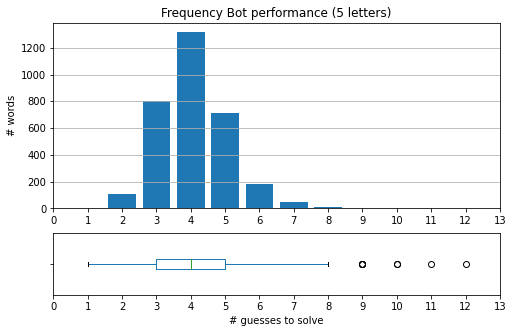

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={
                       'height_ratios': [3, 1]})

results["n_guesses"].hist(
    bins=range(1, results["n_guesses"].max()+1),
    align="left",
    rwidth=.8,
    ax=ax[0]
)

results.boxplot(
    column="n_guesses",
    ax=ax[1],
    vert=False,
    grid=False
)

ax[0].set_title("Frequency Bot performance (5 letters)")
ax[0].set_ylabel("# words")
ax[0].set_xticks(range(0, results["n_guesses"].max()+2))
ax[0].grid(axis='x')

ax[1].set_xlabel("# guesses to solve")
ax[1].set_xticks(range(0, results["n_guesses"].max()+2))
ax[1].set_yticklabels("")


The above plot gives a better sense of the number of moves it takes for FrequencyBot to solve Wordle. The distribution is heavily centred around __4 moves__.

But let's say we want to know how often FrequencyBot can successfully solve Wordle regardless of the number of moves?

<AxesSubplot:title={'center':'Solved Successfully'}, ylabel='solved'>

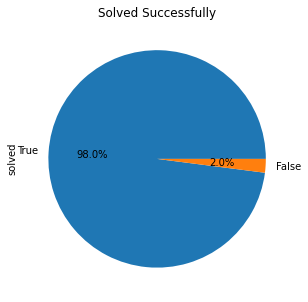

In [10]:
results["solved"] = results["n_guesses"] <= 6

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.set_title("Solved Successfully")

results["solved"].value_counts().plot.pie(ax=ax, autopct='%1.1f%%')


Yep! __98 percent__ of the time, FrequencyBot can solve Wordle.

I don't know about you, but I personally find Wordle very challenging, so it's nice to know FrequencyBot has my back :D

### 4 Letter Words

Let's take a quick peek at how Wordle does for a simpler(?) case... 4 letter words.

There are fewer 4 letter words than 5 letter words, so the search space is smaller.

In [11]:
stats = defaultdict(int)
words = {w for w in english_words_lower_set if len(
    w) == 4 and re.match(r'^\w+$', w)}
print(len(words))

for w in words:
    wdl = Wordle(w)
    bot = FrequencyBot(n_char=len(w))

    current_guess = None

    while current_guess != wdl.solution:
        current_guess = bot.predict()[0][0]
        result = wdl.guess(current_guess)
        bot.update(current_guess, result)

    stats[w] = {
        "n_guesses": len(wdl.guesses)
    }

results = pd.DataFrame.from_dict(stats, orient='index')
results["n_guesses"].describe()


2196


count    2196.000000
mean        5.253188
std         1.751436
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        13.000000
Name: n_guesses, dtype: float64

Uh oh! Looks like FrequencyBot struggles more with 4 letter words. It takes an average of __5 moves__ to solve a 4-letter Wordle.

[Text(0, 1, '')]

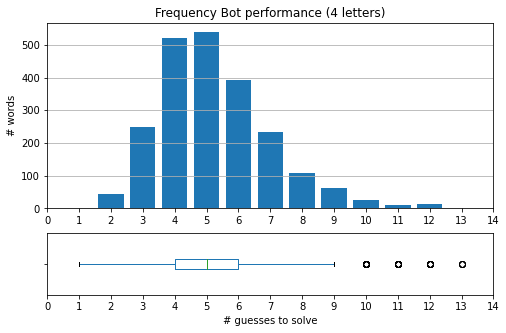

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={
                       'height_ratios': [3, 1]})

results["n_guesses"].hist(
    bins=range(1, results["n_guesses"].max()+1),
    align="left",
    rwidth=.8,
    ax=ax[0]
)

results.boxplot(
    column="n_guesses",
    ax=ax[1],
    vert=False,
    grid=False
)

ax[0].set_title("Frequency Bot performance (4 letters)")
ax[0].set_ylabel("# words")
ax[0].set_xticks(range(0, results["n_guesses"].max()+2))
ax[0].grid(axis='x')

ax[1].set_xlabel("# guesses to solve")
ax[1].set_xticks(range(0, results["n_guesses"].max()+2))
ax[1].set_yticklabels("")


<AxesSubplot:title={'center':'Solved Successfully'}, ylabel='solved'>

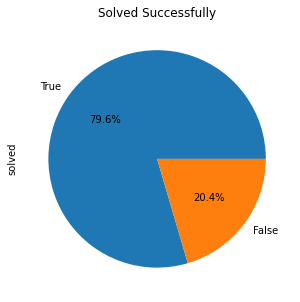

In [13]:
results["solved"] = results["n_guesses"] <= 6

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.set_title("Solved Successfully")

results["solved"].value_counts().plot.pie(ax=ax, autopct='%1.1f%%')


FrequencyBot can only solve about 80% of 4-letter Wordles.

We might explain this with the fact that with shorter words there is less information to be gotten from each guess.

### 6 Letter Words

If our hunch about 4-letter words is right, we might expect FrequencyBot to do better on longer Wordles.

Let's look at 6 letter words (of which there are 3890)

In [14]:
stats = defaultdict(int)
words = {w for w in english_words_lower_set if len(
    w) == 6 and re.match(r'^\w+$', w)}
print(len(words))

for w in words:
    wdl = Wordle(w)
    bot = FrequencyBot(n_char=len(w))

    current_guess = None

    while current_guess != wdl.solution:
        current_guess = bot.predict()[0][0]
        result = wdl.guess(current_guess)
        bot.update(current_guess, result)

    stats[w] = {
        "n_guesses": len(wdl.guesses)
    }

results = pd.DataFrame.from_dict(stats, orient='index')
results["n_guesses"].describe()


3890


count    3890.000000
mean        3.505141
std         0.809496
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         7.000000
Name: n_guesses, dtype: float64

Sure enough, FrequencyBot's performance is even better than the 5-letter case!

The hardest Wordle only took 7 guesses. I wonder if it's __taters__??

In [15]:
results[results["n_guesses"] == 7]


,n_guesses
bobble,7
bumble,7
deride,7
farley,7
giggle,7
strike,7
stroke,7


Sadly, no, taters wasn't one of them.

However, we can see a pattern emerge where many of these "difficult" words involve repeated letters.

This might stem from the fact that Wordle doesn't indicate how many times a letter appears in a word, only whether it's 1) in the word at all, and 2) whether it's in the guessed position or not.

This makes identifying words with repeated letters more difficult, not just for FrequencyBot, but for humans too since there's a bias to try _unused_ letters to weed out candidates.

[Text(0, 1, '')]

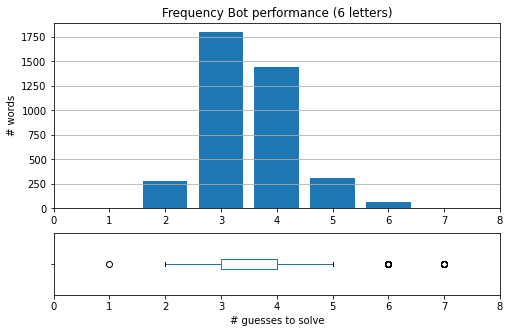

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={
                       'height_ratios': [3, 1]})

results["n_guesses"].hist(
    bins=range(1, results["n_guesses"].max()+1),
    align="left",
    rwidth=.8,
    ax=ax[0]
)

results.boxplot(
    column="n_guesses",
    ax=ax[1],
    vert=False,
    grid=False
)

ax[0].set_title("Frequency Bot performance (6 letters)")
ax[0].set_ylabel("# words")
ax[0].set_xticks(range(0, results["n_guesses"].max()+2))
ax[0].grid(axis='x')

ax[1].set_xlabel("# guesses to solve")
ax[1].set_xticks(range(0, results["n_guesses"].max()+2))
ax[1].set_yticklabels("")


<AxesSubplot:title={'center':'Solved Successfully'}, ylabel='solved'>

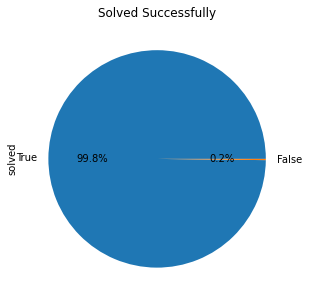

In [17]:
results["solved"] = results["n_guesses"] <= 6

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.set_title("Solved Successfully")

results["solved"].value_counts().plot.pie(ax=ax, autopct='%1.1f%%')


And there we have it:

FrequencyBot can solve __99.8%__ of 6-letter Wordles!